In [1]:
import numpy as np
import joblib
from setfit import SetFitModel
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import json
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Test Data -> annotated.json

In [2]:
class Preprocessing_JSON_annotated_Seniority:
    """
    Loads an annotated JSON file (list of persons, each a list of jobs).
    Keeps ONLY the latest ACTIVE job per person (by startDate).
    Returns:
      - self.X: pd.Series of cleaned positions (text)
      - self.y: pd.Series of raw string labels (seniority)  # NOT encoded
      - self.df: DataFrame with columns ["text", "label"]
    """

    def __init__(self, path: str):
        self.path = path
        self.df: pd.DataFrame | None = None
        self.X: pd.Series | None = None
        self.y: pd.Series | None = None

        self.read_json()

    @staticmethod
    def _parse_year_month(s):
        """Expects 'YYYY-MM' -> (year, month) or None."""
        if not isinstance(s, str) or len(s) < 7:
            return None
        try:
            year, month = s.split("-")
            return int(year), int(month)
        except Exception:
            return None

    @staticmethod
    def clean_text(text: str) -> str:
        return str(text).lower().strip().replace("-", " ").replace("/", " ")

    def read_json(self):
        with open(self.path, "r", encoding="utf-8") as f:
            data = json.load(f)

        rows = []

        for person_jobs in data:
            if not isinstance(person_jobs, list):
                continue

            active_jobs = []
            for job in person_jobs:
                if not isinstance(job, dict):
                    continue
                if job.get("status") != "ACTIVE":
                    continue

                start = self._parse_year_month(job.get("startDate"))
                if start is None:
                    continue

                active_jobs.append((start, job))

            if not active_jobs:
                continue

            _, job = max(active_jobs, key=lambda x: x[0])

            position = job.get("position")
            seniority = job.get("seniority")

            if not position or not seniority:
                continue

            rows.append(
                {"text": self.clean_text(position), "label": str(seniority)}
            )

        self.df = pd.DataFrame(rows)
        if self.df.empty:
            raise ValueError("No valid samples found in JSON")

        self.X = self.df["text"].astype(str)
        self.y = self.df["label"].astype(str)

        print(f"[JSON] Loaded {len(self.df)} samples from {self.path}")

In [3]:
data = Preprocessing_JSON_annotated_Seniority(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json",
)

X_test = data.X
y_test_raw = data.y

encoder = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/encoder_seniority.joblib")
y_test = encoder.transform(y_test_raw.values.reshape(-1,1)).flatten()

[JSON] Loaded 457 samples from /Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json


#### Pipeline:

In [4]:
# Load BOW + Logistic Regression Model
bow_lr_model = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/bow_seniority.joblib")

bow_lr_model

Pipeline(steps=[('bow', CountVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('ros', RandomOverSampler(random_state=123)),
                ('clf',
                 LogisticRegression(C=10, max_iter=2000, solver='liblinear'))])

In [5]:
# Huggingface Model
model_hf = SetFitModel.from_pretrained(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/setfit_seniority",
    local_files_only=True
)

The tokenizer you are loading from '/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/setfit_seniority' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [6]:
enc_order = list(encoder.categories_[0])
hf_labels = list(model_hf.labels)

idx = [hf_labels.index(c) for c in enc_order]

aligned_label_order = [hf_labels[i] for i in idx]
print("HF labels (original):", hf_labels)
print("HF labels (reordered):", aligned_label_order)
print("Encoder order:", enc_order)

assert aligned_label_order == enc_order, "Alignment failed: reordered HF labels != encoder order"


HF labels (original): ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']
HF labels (reordered): ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']
Encoder order: ['Junior', 'Professional', 'Senior', 'Lead', 'Management', 'Director']


In [7]:
enc_classes = np.array(encoder.categories_[0], dtype=object)
enc_order = list(enc_classes)

def setfit_proba_aligned_to_encoder(model_hf, texts, enc_order):
    """
    SetFit predict_proba columns are in model_hf.labels order.
    Reorder them to match enc_order.
    """
    P = np.asarray(model_hf.predict_proba(texts))
    hf_labels = list(model_hf.labels)
    idx = [hf_labels.index(c) for c in enc_order]
    return P[:, idx]

def soft_vote_predict(model_bow, model_hf, X_texts, enc_classes, w_bow=0.2, w_hf=0.8):
    X_texts = list(X_texts)

    P_bow = model_bow.predict_proba(X_texts)
    P_hf  = setfit_proba_aligned_to_encoder(model_hf, X_texts, list(enc_classes))

    P_ens = (w_bow * P_bow + w_hf * P_hf) / (w_bow + w_hf)
    y_pred = enc_classes[np.argmax(P_ens, axis=1)]
    return y_pred, P_ens

X_test_texts = X_test.squeeze().astype(str).tolist()
y_test_str = y_test_raw.to_numpy()

y_pred_hf = np.array(model_hf.predict(X_test_texts), dtype=object)

print("HF Accuracy:", accuracy_score(y_test_str, y_pred_hf))
print("HF Macro F1:", f1_score(y_test_str, y_pred_hf, average="macro"))

y_pred_soft, P_ens = soft_vote_predict(
    bow_lr_model, model_hf, X_test_texts, enc_classes,
    w_bow=0.2, w_hf=0.8
)

print("\nSoftVote Accuracy:", accuracy_score(y_test_str, y_pred_soft))
print("SoftVote Macro F1:", f1_score(y_test_str, y_pred_soft, average="macro"))

print("\nSoftVote report:")
print(classification_report(
    y_test_str, y_pred_soft,
    labels=enc_order, target_names=enc_order,
    zero_division=0
))



HF Accuracy: 0.7789934354485777
HF Macro F1: 0.7348907574575904

SoftVote Accuracy: 0.774617067833698
SoftVote Macro F1: 0.730206015185067

SoftVote report:
              precision    recall  f1-score   support

      Junior       0.60      0.30      0.40        10
Professional       0.70      0.86      0.77       154
      Senior       0.96      0.69      0.81        39
        Lead       0.85      0.71      0.78        97
  Management       0.78      0.77      0.78       133
    Director       0.87      0.83      0.85        24

    accuracy                           0.77       457
   macro avg       0.80      0.69      0.73       457
weighted avg       0.79      0.77      0.77       457



<Figure size 12000x12000 with 0 Axes>

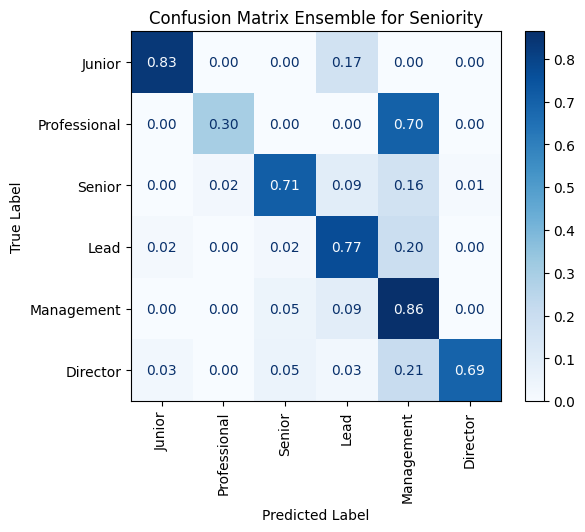

In [9]:
cm_norm = confusion_matrix(
    y_test_str,
    y_pred_soft,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=encoder.categories[0])
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix Ensemble for Seniority")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/cm_ensemble_seniority.png", bbox_inches="tight")
plt.show()

Compare with Huggingface model alone

In [10]:
y_pred_hf = np.array(model_hf.predict(X_test_texts), dtype=object)

print("HF Accuracy:", accuracy_score(y_test_str, y_pred_hf))
print("HF Macro F1:", f1_score(y_test_str, y_pred_hf, average="macro"))
print(classification_report(
    y_test_str, y_pred_hf,
    labels=enc_order, target_names=enc_order,
    zero_division=0
))


HF Accuracy: 0.7789934354485777
HF Macro F1: 0.7348907574575904
              precision    recall  f1-score   support

      Junior       0.60      0.30      0.40        10
Professional       0.70      0.88      0.78       154
      Senior       1.00      0.69      0.82        39
        Lead       0.88      0.71      0.79        97
  Management       0.78      0.77      0.78       133
    Director       0.87      0.83      0.85        24

    accuracy                           0.78       457
   macro avg       0.81      0.70      0.73       457
weighted avg       0.79      0.78      0.78       457

